In [1]:
import ee
from IPython import display
from IPython.display import Image
import math
import matplotlib.pyplot as plt
from osgeo import gdal
import tempfile
import urllib
import zipfile
from mpl_toolkits.basemap import Basemap
import numpy as np
import datetime

In [2]:
ee.Initialize()

# VETTORI
countries = ee.FeatureCollection('ft:1tdSwUL7MVpOauSgRzqVTOwdfy17KDbw-1d9omPw')
wsheds = ee.FeatureCollection('ft:1IXfrLpTHX4dtdj1LcNXjJADBB-d93rkdJ9acSEWK')

# COLLEZIONI RASTER
L1_AGBPSeasonals = ee.ImageCollection("projects/fao-wapor/L1_AGBP")
L1_AGBPDekadal = ee.ImageCollection("projects/fao-wapor/L1_AGBP250")
ETaCollection = ee.ImageCollection("projects/fao-wapor/L1_AET")
AET250 = ee.ImageCollection("users/lpeiserfao/AET250")

In [3]:
# AREA OF INTEREST
region = [[-25.0, -40.0], [65.0, -40.0], [65.0, 40.0], [-30.0, 40.0], [-30.0, -40.0]]

In [4]:
def genera_wbpm(agbp,aet):    
    
    L1_AGBPMasked = agbp.map(lambda lista: lista.updateMask(lista.gte(0)))
    L1_AGBPSummed = L1_AGBPMasked.sum(); #.multiply(10); 
    ETaColl1 = aet.map(lambda immagine: immagine.updateMask(immagine.lt(254) and (immagine.gt(0)))) 
    ETaColl2 = ETaColl1.map(lambda immagine: immagine.addBands(immagine.metadata('days_in_dk')));
    ETaColl3 = ETaColl2.map(lambda immagine: immagine.select('b1').divide(10).multiply(immagine.select('days_in_dk'))).sum()
    ETaTotm3 = ETaColl3.multiply(10)
    WPbm = L1_AGBPSummed.divide(ETaTotm3)
    return WPbm

In [5]:
def vizualize_image(wbpm,regione_paese,scala):    
    visparams = {"opacity":1,
             "min":0,
             "max":1.2,
             "palette":"bc170f,e97a1a,fff83a,9bff40,5cb326",
             "region": regione_paese,
             "scale" : scala}
    
    url_WPbm = wbpm.getThumbUrl(visparams)
    return url_WPbm

# Statistiche WPbm per paese e bacino per periodo 

In [6]:
data_start = datetime.datetime(2015, 1, 1)
data_end = datetime.datetime(2015, 3, 30)

AGBPFiltered = L1_AGBPDekadal.filterDate(
     data_start,
     data_end)

AETFiltered = AET250.filterDate(
      data_start,
      data_end)

# Get the number of images.
count_agbp = AGBPFiltered.size().getInfo();
count_aet = AETFiltered.size().getInfo();
print('agbp: {} aet: {} '.format(count_agbp,count_aet))

wbpm_calc = genera_wbpm(AGBPFiltered,AETFiltered)

nomeCountry = 'Benin'
justCountry = countries.filter(ee.Filter.eq('Country', nomeCountry))
raster_tagliato = wbpm_calc.clip(justCountry)
cutPoly = justCountry.geometry()
cutBoundingBox = cutPoly.bounds(1)
regione_paese = ee.Geometry(cutPoly.getInfo()).toGeoJSONString()

scala = wbpm_calc.projection().nominalScale().getInfo()
visualizzazione = vizualize_image(wbpm_calc,regione_paese,scala)
Image(url=visualizzazione)

agbp: 15 aet: 9 


In [7]:
country_stats = wbpm_calc.reduceRegion(
    reducer = ee.Reducer.mean(),
    geometry = cutPoly,
    scale = scala,
    maxPixels = 1e9
)
print country_stats.getInfo()

{u'b1': 0.030459171532817735}


In [8]:
benin_histo = wbpm_calc.reduceRegion(
    reducer = ee.Reducer.histogram(10),
    geometry = cutPoly,
    scale = scala,
    maxPixels = 1e9
)
#benin_histo.getInfo()

In [9]:
benin_freq_histo = wbpm_calc.reduceRegion(
    reducer = ee.Reducer.frequencyHistogram(),
    geometry = cutPoly,
    scale = scala,
    maxPixels = 1e9
)
#benin_freq_histo.getInfo()

In [10]:
cutBoundingBox = cutPoly.bounds(1)
cutBoundingBox.getInfo()

{u'coordinates': [[[0.7766665000000001, 6.210678999999974],
   [3.8550000000000004, 6.210678999999974],
   [3.8550000000000004, 12.393320000000024],
   [0.7766665000000001, 12.393320000000024],
   [0.7766665000000001, 6.210678999999974]]],
 u'geodesic': False,
 u'type': u'Polygon'}

# Statistiche Evapotranspiration (TimeSerie) per paese e bacino per periodo 

In [11]:
nomeCountry = 'Sudan'
justCountry = countries.filter(ee.Filter.eq('Country', nomeCountry))
cutPoly = justCountry.geometry() 
cutBoundingBox = cutPoly.bounds(1)
regione_paese = ee.Geometry(cutPoly.getInfo()).toGeoJSONString()
centroid = justCountry.geometry().centroid()
data_start = datetime.datetime(2015, 1, 1)
data_end = datetime.datetime(2015, 6, 30)

ETaCollection_filtered = ETaCollection.filterDate(data_start,data_end).filterBounds(cutBoundingBox)

In [12]:
def getMean(img):
    return img.reduceRegions(cutBoundingBox, 
                             ee.Reducer.mean(),
                             200)
ans = ee.FeatureCollection(ETaCollection_filtered.map(getMean)).flatten().aggregate_array('.all').getInfo()

In [13]:
x_agbp = [x['properties']['mean'] for x in ans]
print x_agbp
labels_agbp = [x['id'][:8] for x in ans]
lables_data = [datetime.datetime.strptime(label,"%Y%m%d").strftime('%Y-%m-%d') for label in labels_agbp]

[87.63486691457805, 88.37334525501423, 92.06528750065223, 89.9274704921221, 90.89792543114011, 90.99479320638922, 93.39173424429738, 93.07005694218682, 90.48362029999359, 89.38059918822017, 88.80718158728651, 91.0330225721364, 92.33255210131662, 94.15497041897501, 96.52812765880088, 99.64516271453024, 99.41228565727192, 98.36263230261528]


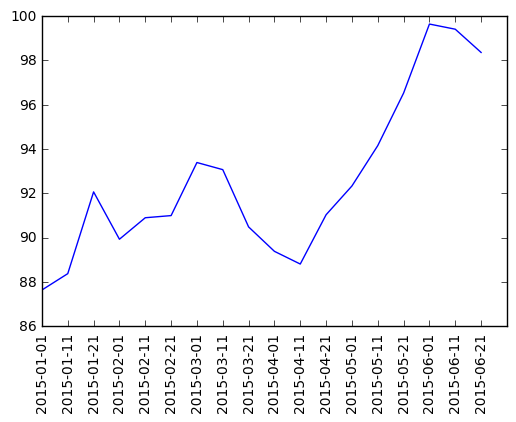

In [14]:
plt.plot(x_agbp)
plt.xticks(range(len(labels_agbp)), lables_data, rotation= 90)
plt.show()